In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import math
import cv2
import random
import datetime as dt

from collections import deque
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping


Install **pafy** library for youtube video download.

In [ ]:
%%capture
!pip  install pafy youtube-dl moviepy

Choose a random seed and set it so that we will get same results during each iteration.

In [ ]:
seed = 27
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

## **1. Download the data and perform EDA**

For activity recognization I will use UCF50-Action Recognization Dataset, consisting of videos taken in real life which are downloaded from youtube.
<br>

Information about dataset

- `133` videos per category
- `50` Action categories
- `26` frames per second per video
- `320` $\times$ `240` dimention of each video.
- `133` videos per category


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


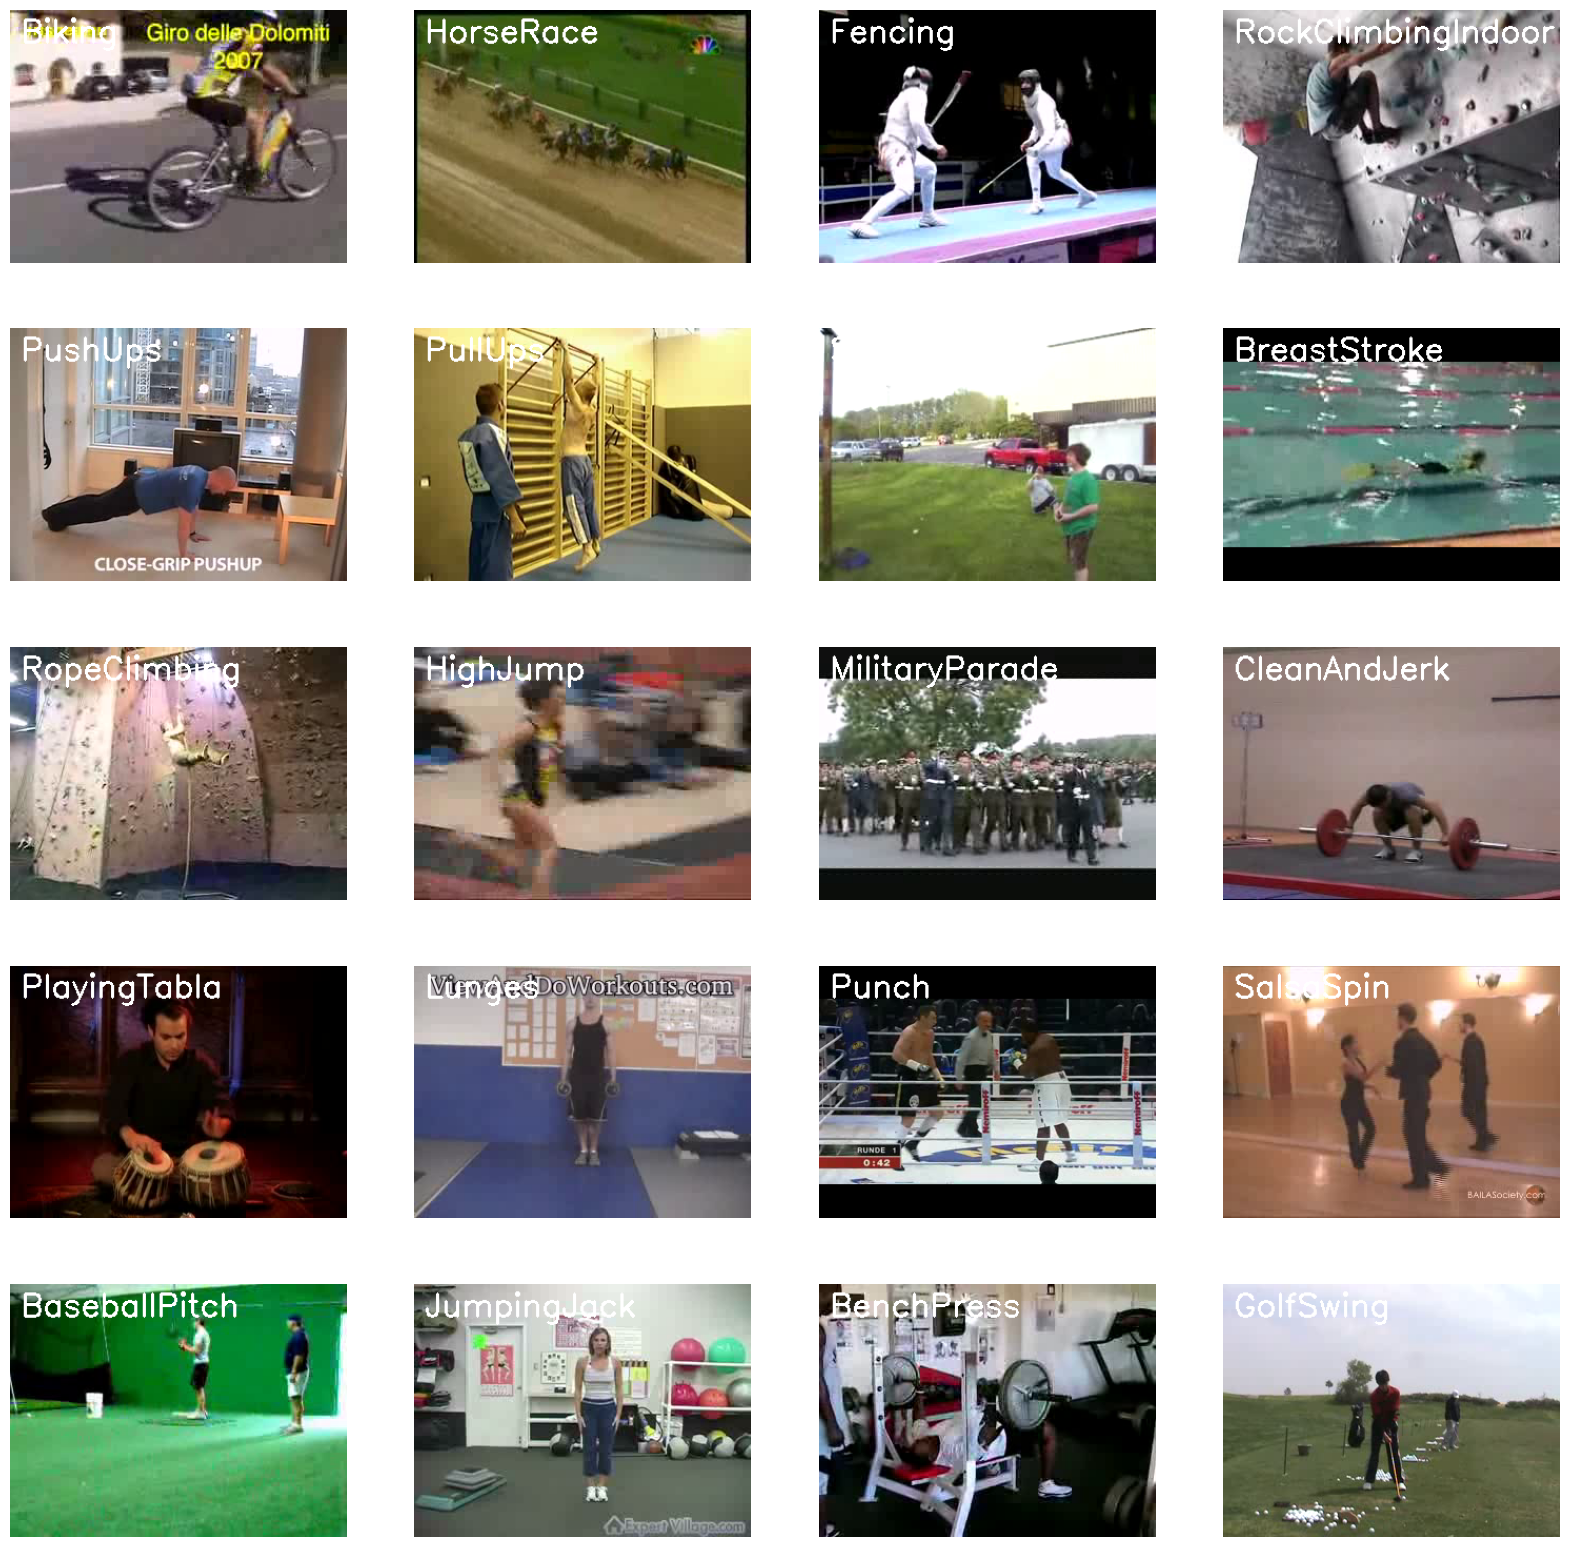

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Ensure the drive is mounted if using Google Colab (uncomment the following lines if needed)
# from google.colab import drive
# drive.mount('/content/drive')

# Define the path to the dataset
dataset_path = '/content/drive/My Drive/UCF50/'  # Adjust this path as necessary

# Get classnames
all_classes_names = os.listdir(dataset_path)

# Randomly display 20 datapoints from the dataset
rand_range = random.sample(range(len(all_classes_names)), 20)

plt.figure(figsize=(20, 20))

for counter, index in enumerate(rand_range, 1):
    selected_class = all_classes_names[index]

    # Retrieve all videos in the randomly selected directory
    video_files_names = os.listdir(os.path.join(dataset_path, selected_class))

    # Select any file randomly from that class
    selected_video_file = random.choice(video_files_names)

    # Read video with cv2
    video_read = cv2.VideoCapture(os.path.join(dataset_path, selected_class, selected_video_file))

    # Start reading from first frame
    success, bgr_frame = video_read.read()

    video_read.release()

    if not success:
        continue

    # Convert frame to standard RGB format
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Display class name on video file
    cv2.putText(rgb_frame, selected_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display frame
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

plt.show()


In [ ]:
# Get number of classes
len(all_classes_names)

50

## 2. Data PreProcessing

We will do some preprocessing steps like normalizing the data, and defining some constants that will be used later on

In [ ]:
import os
import random
import cv2
import numpy as np

IMG_HEIGHT, IMG_WIDTH = 64, 64
SEQUENCE_LENGTH = 30

# Update the dataset directory to point to Google Drive
DATASET_DIR = '/content/drive/MyDrive/UCF50/'

# Choose the classes that we will be used to classify
CLASSES_LIST = ['WalkingWithDog', 'TaiChi', 'Swing', 'HorseRace', 'Kayaking']


### **Extract frames from the video dataset and normalize it**

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    frames_list = [] # stores the frames
    video_reader = cv2.VideoCapture(video_path) # read video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) # get the frames in that video
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1) # find skip interval length

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter*skip_frames_window) # set current frame position of video
        success, frame = video_reader.read() # read frame

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        resized_frame = cv2.resize(frame, (IMG_HEIGHT, IMG_WIDTH)) # resize the frame

        normalized_frame = resized_frame / 255 # normalize the frame

        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

Create a function that will create the dataset.<br>
It will return the:
- Extracted frames
- Indices of the class associated with the video
- Path of the videos

In [ ]:
dog = os.listdir(os.path.join(DATASET_DIR, 'WalkingWithDog')) # get list of video files present for that class
frames = frames_extraction(dog[0]) # extract frames from that video
frames

[]

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting data of class:{class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name)) # get list of video files present for that class

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name) # get complete path

            frames = frames_extraction(video_file_path) # extract frames from that video

            # if the choosen video has frames == SEQUENCE_LENGTH
            # then add it to the features list else skip the video

            if(len(frames)==SEQUENCE_LENGTH):
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.array(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

Call the `create_dataset` function.<br>
This will give `30` preprocessed frames for each category.

In [ ]:
 features, labels, video_files_paths = create_dataset()

Extracting data of class:WalkingWithDog
Extracting data of class:TaiChi
Extracting data of class:Swing
Extracting data of class:HorseRace
Extracting data of class:Kayaking


In [ ]:
# features
# labels
# video_files_paths

One hot encode the `labels`

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
one_hot_encoded_labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

## **Step 3. Split into training and testing**

In [ ]:
f_train, f_test, l_train, l_test = train_test_split(features, one_hot_encoded_labels,
                                                   test_size = 0.25, shuffle = True,
                                                   random_state = seed)

## **Step 4. Implementation of ConvLSTM**
![image.png](attachment:5a94e656-847a-4b7e-a17e-a207d01876a3.png)

- ConvLSTM is a type of recurrent neural network for spatio-temporal prediction that has convolutional structures in both the input-to-state and state-to-state transitions.

- ConvLSTM works with `3-D inputs` where as LSTM work with single dimentional data.

- The ConvLSTM determines the future state of a certain cell in the grid by the inputs and past states of its local neighbors. This can easily be achieved by using a convolution operator in the state-to-state and input-to-state transitions

### **Construction of Model**

We will use `ConvLSTM2D` functionality of the Keras API.Inputs accepted are:
- Number of filters
- Kernel size
- Activation function
- Input shape

The output of convolutional layer is flattened and fed to the `Dense` layer and `softmax` activation function is used to predict the class.

- `Maxpooling3D` is used to reduce the dimension of the data to minimize the computation.
- `Dropout` layer is added to prevent overfitting where `keep_prob` is set to `0.2`.

In [ ]:
def create_convlstm_model():
    model = Sequential()

    # Model architecture
    # -------------------------------------------------------------------------------------------------------
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2,
                        input_shape = (SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3),
                        return_sequences = True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2, return_sequences = True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2, return_sequences = True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2, return_sequences = True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    # -------------------------------------------------------------------------------------------------------
    # Print model summary
    model.summary()

    return model

Invoke the `create_convlstm_model()` function to create the `ConvLSTM` model and display it's symmary

In [ ]:
conv_lstm = create_convlstm_model()

print("Model creation successful")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 30, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 30, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 30, 15, 15, 8)     0         
 g3D)                                                            
                                                        

Use `plot_model()` function to get a beautiful view of the model architecture.

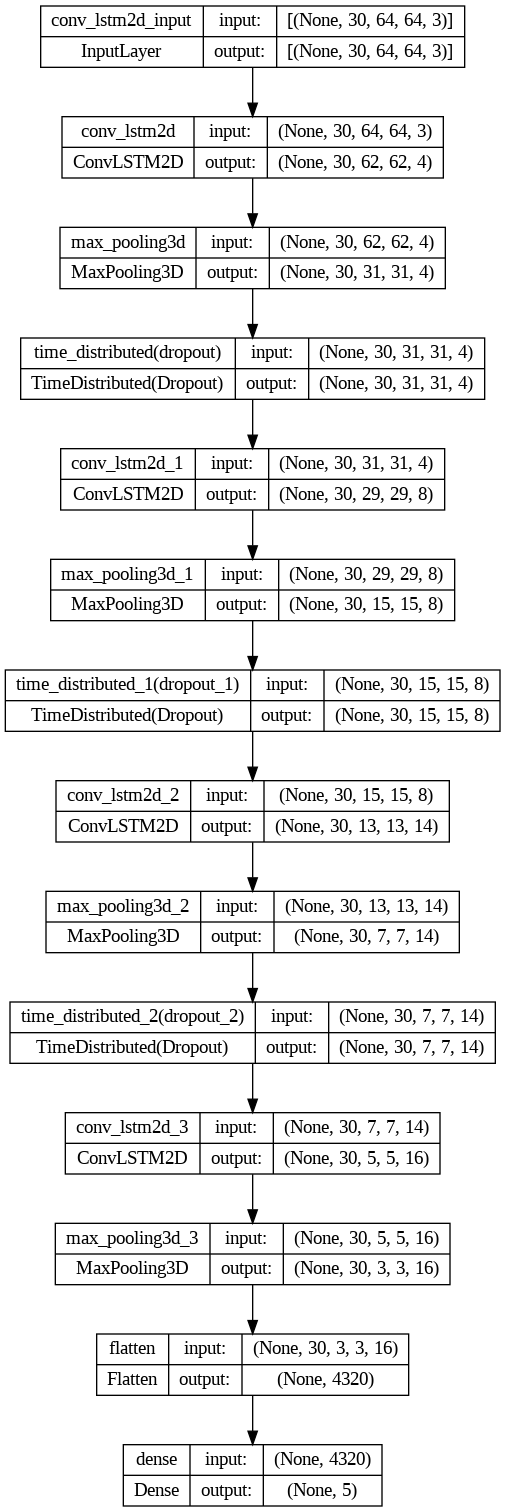

In [ ]:
plot_model(conv_lstm, to_file='convlstm_model_architecture.png',
          show_shapes=True, show_layer_names = True)

#### **Compile and Train the Model**

In [ ]:
%%time
# we can call Early Stopping Callback if we need
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# compile the model with loss as categorical_crossentropy

conv_lstm.compile(loss = 'categorical_crossentropy', optimizer='Adam',
                 metrics=['accuracy'])

# train the model
conv_lstm_train_hist = conv_lstm.fit(x = f_train, y = l_train, epochs = 50,
                                    batch_size = 5, shuffle = True,
                                     validation_split=0.2, callbacks = [early_stopping_callback])

Epoch 1/50
79/79 [==============================] - 301s 4s/step - loss: 1.5818 - accuracy: 0.2380 - val_loss: 1.3944 - val_accuracy: 0.2929
Epoch 2/50
79/79 [==============================] - 306s 4s/step - loss: 1.3762 - accuracy: 0.4177 - val_loss: 1.2255 - val_accuracy: 0.5455
Epoch 3/50
79/79 [==============================] - 269s 3s/step - loss: 1.2459 - accuracy: 0.4759 - val_loss: 1.1936 - val_accuracy: 0.4949
Epoch 4/50
79/79 [==============================] - 270s 3s/step - loss: 1.0095 - accuracy: 0.6051 - val_loss: 1.0116 - val_accuracy: 0.5960
Epoch 5/50
79/79 [==============================] - 269s 3s/step - loss: 0.8349 - accuracy: 0.6582 - val_loss: 0.9297 - val_accuracy: 0.6465
Epoch 6/50
79/79 [==============================] - 268s 3s/step - loss: 0.7482 - accuracy: 0.7241 - val_loss: 0.8980 - val_accuracy: 0.6566
Epoch 7/50
79/79 [==============================] - 269s 3s/step - loss: 0.6535 - accuracy: 0.7190 - val_loss: 0.7881 - val_accuracy: 0.7172
Epoch 8/50
79

## **Evaluate the model**

In [ ]:
model_evaluation_history = conv_lstm.evaluate(f_test, l_test)

6/6 [==============================] - 29s 5s/step - loss: 0.8486 - accuracy: 0.7758


## **Save the Model**

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'Conv_LSTM_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
conv_lstm.save(model_file_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **Plot the model metrics**

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

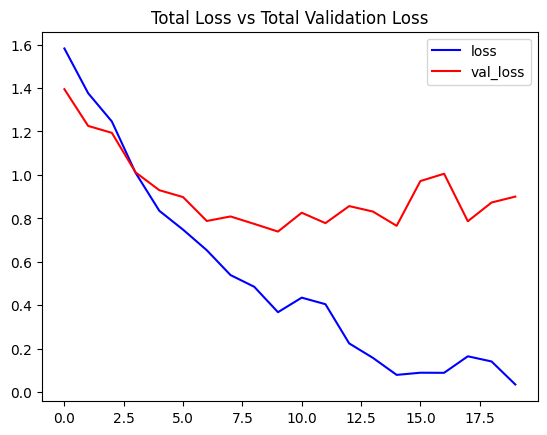

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(conv_lstm_train_hist, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

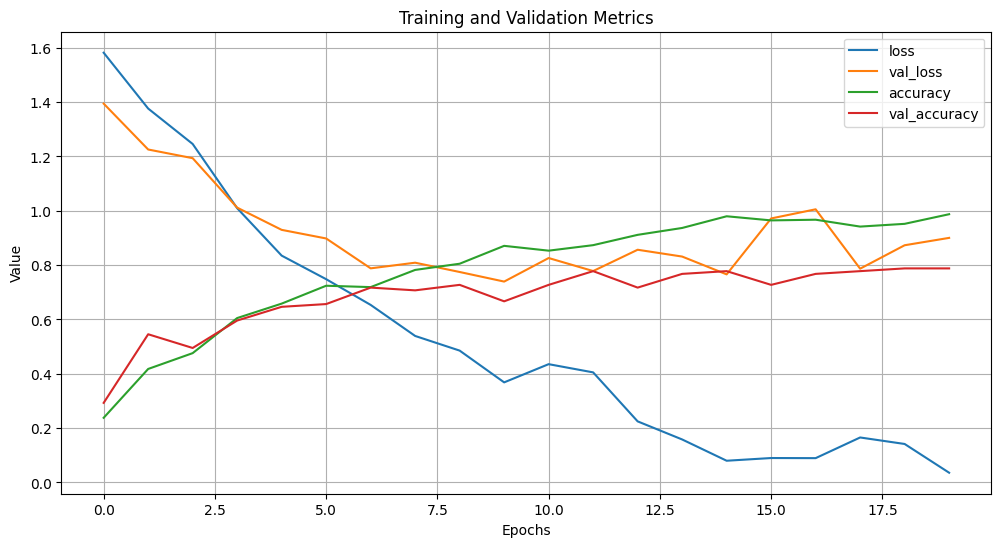

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(history, *metrics):
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], label=metric)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.title('Training and Validation Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming conv_lstm_train_hist contains your training history
plot_metric(conv_lstm_train_hist, 'loss', 'val_loss', 'accuracy', 'val_accuracy')


In [ ]:
# Get the highest accuracy obtained during training
highest_accuracy = max(conv_lstm_train_hist.history['accuracy'])

print("Highest accuracy obtained during training:", highest_accuracy)


Highest accuracy obtained during training: 0.9873417615890503
